In [1]:
from pisces.experiments import evaluate_mo_on_data_set, MOResUNetPretrained
from pisces.experiments import DataSetObject
from pisces.utils import add_rocs, plot_scores_PDF


sets = DataSetObject.find_data_sets("../data_sets")
hfd = sets['henry_ford_disordered']

In [2]:

from pisces.experiments import LeaveOneOutSplitter, SGDLogisticRegression, run_splits

loo = LeaveOneOutSplitter()
walch = sets['walch_et_al']

split_models, log_reg_preprocessed_data_walch, splits = run_splits(loo, walch, SGDLogisticRegression)

ID 7749105 not found in walch_et_al


31it [00:02, 11.12it/s]


In [3]:
# TODO: debug this, X_folded.shape[0] != y_prepped.shape[0] (688 vs 668)

# split_models_hf, log_reg_preprocessed_data_hf, splits_hf = run_splits(loo, hfd, SGDLogisticRegression)

In [4]:


from typing import Dict, List

from pisces.experiments import split_analysis
log_reg_aucs_hf = []
log_reg_fprs_hf = []
log_reg_tprs_hf = []



DATA_SET = hfd

log_reg_preprocessed_data_hf = [
    (d, DATA_SET.ids[i])
    for i in range(len(split_models))
    if (d := split_models[0].get_needed_X_y(DATA_SET, DATA_SET.ids[i])) is not None
]

log_reg_evaluations_hf: List[Dict[str, dict]] = []
for i in range(len(split_models)):
    split_evals = {}
    for (X, y), id in log_reg_preprocessed_data_hf:
        y_hat_proba = split_models[i].predict_probabilities(X)
        y_hat_sleep_proba = y_hat_proba[:, 1].reshape(-1,)
        y_prepped, _ = SGDLogisticRegression()._prepare_labels(y)
        try:
            analysis = split_analysis(y_prepped, y_hat_sleep_proba, balancing=False)
        except ValueError as e:
            print(f"Error processing {id}: {e}")
            continue
        # analysis = split_analysis(y, y_hat_proba)
        split_evals[id] = analysis
        print(f"Processed {i+1} of {len(log_reg_preprocessed_data_hf)} ({id})... AUROC: {analysis['auc']}")
    log_reg_evaluations_hf.append(split_evals)
    log_reg_aucs_hf.append([e["auc"] for e in split_evals.values()])
    log_reg_fprs_hf.append([e["roc_curve"]["fprs"] for e in split_evals.values()])
    log_reg_tprs_hf.append([e["roc_curve"]["tprs"] for e in split_evals.values()])


/Users/eric/Engineering/Work/pisces/pisces/experiments.py:546: UserWarning: input has 0 < 11 samples. Returning a zero-padded array.
  warnings.warn(f"input has {input_X.shape[0]} < {self.input_dim} samples. Returning a zero-padded array.")
/Users/eric/Engineering/Work/pisces/pisces/utils.py:409: UserWarning: y_hat is shorter than y by 935 elements, trimming y
  warnings.warn(f"y_hat is shorter than y by {-pad} elements, trimming y")
/opt/homebrew/Caskroom/miniforge/base/envs/pisces/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/pisces/lib/python3.11/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/opt/homebrew/Caskroom/minifor

Processed 1 of 30 (AWS001)... AUROC: 0.42225705329153607
Processed 1 of 30 (AWS002)... AUROC: 0.6399610317313045
Processed 1 of 30 (AWS003)... AUROC: 0.43709827780776217
Processed 1 of 30 (AWS004)... AUROC: 0.6320279349363509
Processed 1 of 30 (AWS005)... AUROC: 0.6580972154372252
Processed 1 of 30 (AWS006)... AUROC: 0.42068921465299736
Processed 1 of 30 (AWS007)... AUROC: 0.632689818351583
Processed 1 of 30 (AWS008)... AUROC: 0.7716839805196007
Error processing AWS009: Only one class present in y_true. ROC AUC score is not defined in that case.
Processed 1 of 30 (AWS010)... AUROC: 0.6314285714285715
Processed 1 of 30 (AWS011)... AUROC: 0.6942094153540515
Processed 1 of 30 (AWS012)... AUROC: 0.5911111111111111
Processed 1 of 30 (AWS013)... AUROC: 0.3887852887852889
Processed 1 of 30 (AWS014)... AUROC: 0.6345599682024444
Processed 1 of 30 (AWS015)... AUROC: 0.7571983356449377
Processed 1 of 30 (AWS016)... AUROC: 0.6386909227306826
Processed 1 of 30 (AWS017)... AUROC: 0.5021521799500139


/Users/eric/Engineering/Work/pisces/pisces/experiments.py:546: UserWarning: input has 0 < 11 samples. Returning a zero-padded array.
  warnings.warn(f"input has {input_X.shape[0]} < {self.input_dim} samples. Returning a zero-padded array.")
/Users/eric/Engineering/Work/pisces/pisces/utils.py:409: UserWarning: y_hat is shorter than y by 935 elements, trimming y
  warnings.warn(f"y_hat is shorter than y by {-pad} elements, trimming y")
/opt/homebrew/Caskroom/miniforge/base/envs/pisces/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/pisces/lib/python3.11/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/opt/homebrew/Caskroom/minifor

Processed 7 of 30 (AWS004)... AUROC: 0.6319591780606633
Processed 7 of 30 (AWS005)... AUROC: 0.6580463279596157
Processed 7 of 30 (AWS006)... AUROC: 0.4207211523106895
Processed 7 of 30 (AWS007)... AUROC: 0.6327057338086749
Processed 7 of 30 (AWS008)... AUROC: 0.7720404421976557
Error processing AWS009: Only one class present in y_true. ROC AUC score is not defined in that case.
Processed 7 of 30 (AWS010)... AUROC: 0.6314495798319327
Processed 7 of 30 (AWS011)... AUROC: 0.6943335816659572
Processed 7 of 30 (AWS012)... AUROC: 0.5910755555555556
Processed 7 of 30 (AWS013)... AUROC: 0.3888111888111888
Processed 7 of 30 (AWS014)... AUROC: 0.6345268457487329
Processed 7 of 30 (AWS015)... AUROC: 0.7573370319001387
Processed 7 of 30 (AWS016)... AUROC: 0.63884096024006
Processed 7 of 30 (AWS017)... AUROC: 0.5020910858094974
Processed 7 of 30 (AWS018)... AUROC: 0.8079543518991654
Processed 7 of 30 (AWS019)... AUROC: 0.7166094356524335
Processed 7 of 30 (AWS020)... AUROC: 0.774126362525255
Proce

/Users/eric/Engineering/Work/pisces/pisces/utils.py:409: UserWarning: y_hat is shorter than y by 541 elements, trimming y
  warnings.warn(f"y_hat is shorter than y by {-pad} elements, trimming y")
/Users/eric/Engineering/Work/pisces/pisces/experiments.py:546: UserWarning: input has 0 < 11 samples. Returning a zero-padded array.
  warnings.warn(f"input has {input_X.shape[0]} < {self.input_dim} samples. Returning a zero-padded array.")
/Users/eric/Engineering/Work/pisces/pisces/utils.py:409: UserWarning: y_hat is shorter than y by 935 elements, trimming y
  warnings.warn(f"y_hat is shorter than y by {-pad} elements, trimming y")
/opt/homebrew/Caskroom/miniforge/base/envs/pisces/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/pisces/lib/python3.11/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A sing

Processed 13 of 30 (AWS006)... AUROC: 0.42063811440068993
Processed 13 of 30 (AWS007)... AUROC: 0.632700428656311
Processed 13 of 30 (AWS008)... AUROC: 0.771484917504583
Error processing AWS009: Only one class present in y_true. ROC AUC score is not defined in that case.
Processed 13 of 30 (AWS010)... AUROC: 0.6313235294117646
Processed 13 of 30 (AWS011)... AUROC: 0.6941739392649354
Processed 13 of 30 (AWS012)... AUROC: 0.5911111111111111
Processed 13 of 30 (AWS013)... AUROC: 0.3888111888111888
Processed 13 of 30 (AWS014)... AUROC: 0.6345875702472038
Processed 13 of 30 (AWS015)... AUROC: 0.7570943134535368
Processed 13 of 30 (AWS016)... AUROC: 0.638737809452363
Processed 13 of 30 (AWS017)... AUROC: 0.5021244098861427
Processed 13 of 30 (AWS018)... AUROC: 0.8078975756543462
Processed 13 of 30 (AWS019)... AUROC: 0.7166442719219668
Processed 13 of 30 (AWS020)... AUROC: 0.7740016462547704
Processed 13 of 30 (AWS021)... AUROC: 0.7317529794149513
Processed 13 of 30 (AWS022)... AUROC: 0.20762

/Users/eric/Engineering/Work/pisces/pisces/experiments.py:546: UserWarning: input has 0 < 11 samples. Returning a zero-padded array.
  warnings.warn(f"input has {input_X.shape[0]} < {self.input_dim} samples. Returning a zero-padded array.")
/Users/eric/Engineering/Work/pisces/pisces/utils.py:409: UserWarning: y_hat is shorter than y by 935 elements, trimming y
  warnings.warn(f"y_hat is shorter than y by {-pad} elements, trimming y")
/opt/homebrew/Caskroom/miniforge/base/envs/pisces/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/pisces/lib/python3.11/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/opt/homebrew/Caskroom/minifor

Processed 19 of 30 (AWS014)... AUROC: 0.6345489273845405
Processed 19 of 30 (AWS015)... AUROC: 0.7571497919556172
Processed 19 of 30 (AWS016)... AUROC: 0.6387003000750187
Processed 19 of 30 (AWS017)... AUROC: 0.5021688419883366
Processed 19 of 30 (AWS018)... AUROC: 0.8080679043888037
Processed 19 of 30 (AWS019)... AUROC: 0.7165248332835672
Processed 19 of 30 (AWS020)... AUROC: 0.7740390611359158
Processed 19 of 30 (AWS021)... AUROC: 0.7317009750812569
Processed 19 of 30 (AWS022)... AUROC: 0.2076271186440678
Processed 19 of 30 (AWS023)... AUROC: 0.5426202521480769
Processed 19 of 30 (AWS024)... AUROC: 0.5800940259144594
Processed 19 of 30 (AWS025)... AUROC: 0.7476180924681577
Processed 19 of 30 (AWS026)... AUROC: 0.7989702015775635
Processed 19 of 30 (AWS028)... AUROC: 0.6911497584541063
Processed 19 of 30 (AWS029)... AUROC: 0.7114371403096377
Processed 19 of 30 (AWS030)... AUROC: 0.6034465192775117
Processed 19 of 30 (AWS031)... AUROC: 0.6558826476088699
Processed 20 of 30 (AWS001)... 

/Users/eric/Engineering/Work/pisces/pisces/utils.py:409: UserWarning: y_hat is shorter than y by 541 elements, trimming y
  warnings.warn(f"y_hat is shorter than y by {-pad} elements, trimming y")
/Users/eric/Engineering/Work/pisces/pisces/experiments.py:546: UserWarning: input has 0 < 11 samples. Returning a zero-padded array.
  warnings.warn(f"input has {input_X.shape[0]} < {self.input_dim} samples. Returning a zero-padded array.")
/Users/eric/Engineering/Work/pisces/pisces/utils.py:409: UserWarning: y_hat is shorter than y by 935 elements, trimming y
  warnings.warn(f"y_hat is shorter than y by {-pad} elements, trimming y")
/opt/homebrew/Caskroom/miniforge/base/envs/pisces/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/pisces/lib/python3.11/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A sing

Processed 25 of 30 (AWS020)... AUROC: 0.774014117881819
Processed 25 of 30 (AWS021)... AUROC: 0.731726977248104
Processed 25 of 30 (AWS022)... AUROC: 0.2076271186440678
Processed 25 of 30 (AWS023)... AUROC: 0.5421183650525977
Processed 25 of 30 (AWS024)... AUROC: 0.5801704697473532
Processed 25 of 30 (AWS025)... AUROC: 0.7475679470464347
Processed 25 of 30 (AWS026)... AUROC: 0.7988606485539
Processed 25 of 30 (AWS028)... AUROC: 0.6911304347826086
Processed 25 of 30 (AWS029)... AUROC: 0.7112634467745109
Processed 25 of 30 (AWS030)... AUROC: 0.6036502830861484
Processed 25 of 30 (AWS031)... AUROC: 0.6557824605931072
Processed 26 of 30 (AWS001)... AUROC: 0.42185807922485036
Processed 26 of 30 (AWS002)... AUROC: 0.6392651697903136
Processed 26 of 30 (AWS003)... AUROC: 0.43697561454295675
Processed 26 of 30 (AWS004)... AUROC: 0.6320574021687884
Processed 26 of 30 (AWS005)... AUROC: 0.6581786354014005
Processed 26 of 30 (AWS006)... AUROC: 0.4206445019322283
Processed 26 of 30 (AWS007)... AUR

/Users/eric/Engineering/Work/pisces/pisces/experiments.py:546: UserWarning: input has 0 < 11 samples. Returning a zero-padded array.
  warnings.warn(f"input has {input_X.shape[0]} < {self.input_dim} samples. Returning a zero-padded array.")
/Users/eric/Engineering/Work/pisces/pisces/utils.py:409: UserWarning: y_hat is shorter than y by 935 elements, trimming y
  warnings.warn(f"y_hat is shorter than y by {-pad} elements, trimming y")
/opt/homebrew/Caskroom/miniforge/base/envs/pisces/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/pisces/lib/python3.11/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/opt/homebrew/Caskroom/minifor

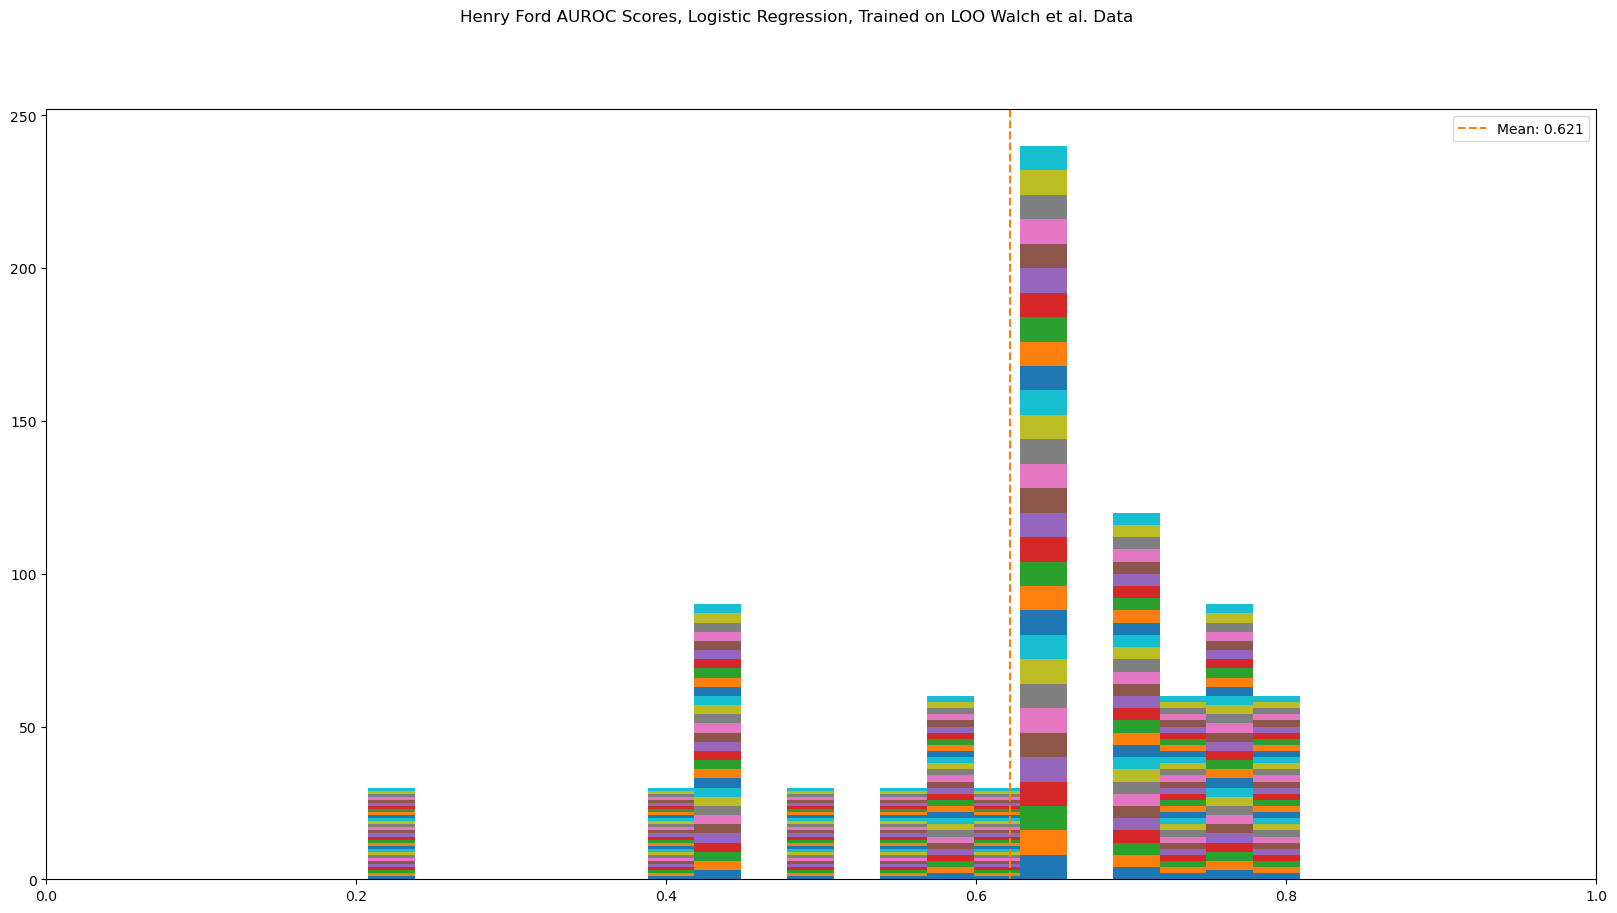

In [5]:
from matplotlib import pyplot as plt


fig, ax = plt.subplots(figsize=(20, 10))
fig.suptitle("Henry Ford AUROC Scores, Logistic Regression, Trained on LOO Walch et al. Data")
plot_scores_PDF(log_reg_aucs_hf, ax=ax)
ax.legend()
# for i in range(len(log_reg_aucs_hf)):
#     plot_scores_PDF(log_reg_aucs_hf[i], ax=ax, hist_alpha=0.1)

# Mads Olsen ResUNet inference

This can probably be improved by fine-tuning on Walch et al.

In [6]:
mo = MOResUNetPretrained(sampling_hz=32)

results = evaluate_mo_on_data_set(mo, hfd)

parallel_execute: Using 16 of 16 cores (100%) for parallel preprocessing.
parallel_execute: This can cause memory or heat issues if  is too high; if you run into problems, call prepare_set_for_training() again with max_workers = -1, going more negative if needed. (See the docstring for more info.)
getting needed X, y for AWS001
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
getting needed X, y for AWS005
getting needed X, y for AWS004
getting needed X, y for AWS008
getting needed X, y for AWS002
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
getting needed X, y for AWS009
getting needed X, y for AWS006
getting needed X, y for AWS003
getting needed X, y for AWS007
getting needed X, y for AWS010
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
sampling_period_s: 0.01

/opt/homebrew/Caskroom/miniforge/base/envs/pisces/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/envs/pisces/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


getting needed X, y for AWS018
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
getting needed X, y for AWS019
getting needed X, y for AWS020
getting needed X, y for AWS021
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
getting needed X, y for AWS022
getting needed X, y for AWS023
sampling_period_s: 0.015151500701904297
resampling to 32Hz (0.03125s) from 66 Hz (0.01515s)
getting needed X, y for AWS024
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
getting needed X, y for AWS025
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
getting needed X

/opt/homebrew/Caskroom/miniforge/base/envs/pisces/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/envs/pisces/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


getting needed X, y for AWS035
getting needed X, y for AWS036
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
getting needed X, y for AWS037
getting needed X, y for AWS038
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
getting needed X, y for AWS039
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
getting needed X, y for AWS040
sampling_period_s: 0.019999980926513672
resampling to 32Hz (0.03125s) from 50 Hz (0.02000s)
1/1 [==============================] - 0s 496ms/step
Processing 1 of 37 (AWS001)... AUROC: 0.4628376606346753
1/1 [==============================] - 0s 135ms/step
Processing 2 of 37 (AWS002)... AUROC: 0.5553022120884853
1/1 [==============================] - 0s 

In [7]:
evaluations_hf, mo_preprocessed_data_hf = results
mo_aucs_hf = [e["auc"] for e in evaluations_hf.values()]
mo_fprs_hf = [e["roc_curve"]["fprs"] for e in evaluations_hf.values()]
mo_tprs_hf = [e["roc_curve"]["tprs"] for e in evaluations_hf.values()]

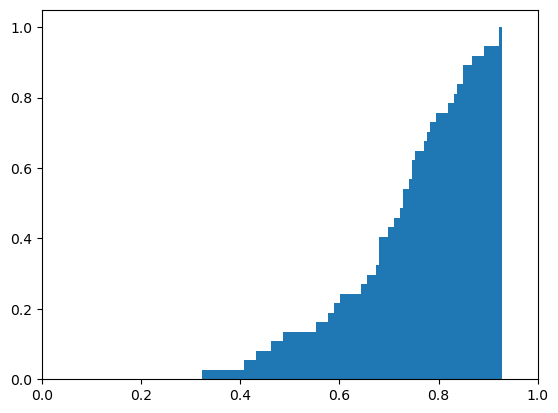

In [8]:



from pisces.utils import plot_scores_CDF


plot_scores_CDF(mo_aucs_hf)

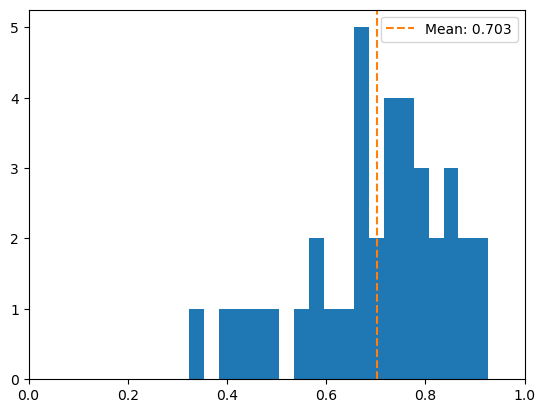

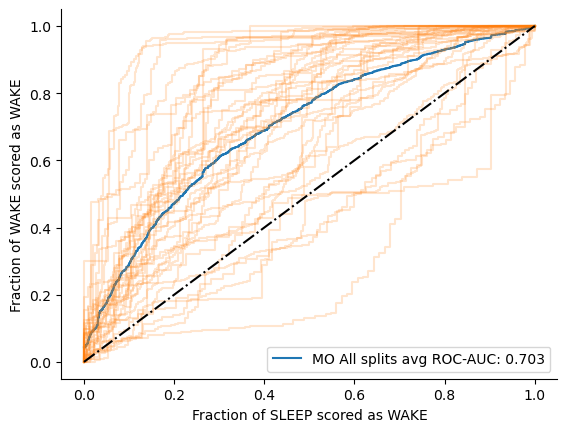

In [9]:

# y so terrible??
# probably timestamp/gap issues
# look at worst ones


plot_scores_PDF(mo_aucs_hf)

add_rocs(mo_fprs_hf, mo_tprs_hf, roc_group_name="MO")